In [1]:
import pandas as pd
import sklearn
import numpy as np
from sklearn import model_selection
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, TargetEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.inspection import permutation_importance
from scipy.signal import find_peaks
from sklearn.metrics import root_mean_squared_error,root_mean_squared_log_error
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFECV, SelectFromModel
import matplotlib.pyplot as plt
import datetime

# Loading and Preprocessing Training Data


In [2]:
train = pd.read_csv('train.csv')

In [3]:
train.describe(include = 'all')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,1460.000000,1460.000000,1460,1201.000000,1460.000000,1460,91,1460,1460,1460,...,1460.000000,7,281,54,1460.000000,1460.000000,1460.000000,1460,1460,1460.000000
unique,NaN,NaN,5,NaN,NaN,2,2,4,4,2,...,NaN,3,4,4,NaN,NaN,NaN,9,6,NaN
top,NaN,NaN,RL,NaN,NaN,Pave,Grvl,Reg,Lvl,AllPub,...,NaN,Gd,MnPrv,Shed,NaN,NaN,NaN,WD,Normal,NaN
freq,NaN,NaN,1151,NaN,NaN,1454,50,925,1311,1459,...,NaN,3,157,49,NaN,NaN,NaN,1267,1198,NaN
mean,730.500000,56.897260,NaN,70.049958,10516.828082,NaN,NaN,NaN,NaN,NaN,...,2.758904,NaN,NaN,NaN,43.489041,6.321918,2007.815753,NaN,NaN,180921.195890
std,421.610009,42.300571,NaN,24.284752,9981.264932,NaN,NaN,NaN,NaN,NaN,...,40.177307,NaN,NaN,NaN,496.123024,2.703626,1.328095,NaN,NaN,79442.502883
min,1.000000,20.000000,NaN,21.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,1.000000,2006.000000,NaN,NaN,34900.000000
25%,365.750000,20.000000,NaN,59.000000,7553.500000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,5.000000,2007.000000,NaN,NaN,129975.000000
50%,730.500000,50.000000,NaN,69.000000,9478.500000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,6.000000,2008.000000,NaN,NaN,163000.000000
75%,1095.250000,70.000000,NaN,80.000000,11601.500000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,8.000000,2009.000000,NaN,NaN,214000.000000


Encoding ordinal features

In [4]:
#list of rankings
conditionRanking = ['Ex', 'Gd','TA','Fa','Po',np.NaN]
exposRank = ['Gd','Av','Mn','No','NA',np.NaN]
finRank = ['GLQ','ALQ','BLQ','Rec','LwQ','Unf','NA',np.NaN]

cats = [conditionRanking, conditionRanking,conditionRanking, conditionRanking, exposRank, finRank,conditionRanking]

enc = OrdinalEncoder(categories= cats)
enc.fit(train[['ExterQual', 'ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','KitchenQual']])
train[['ExterQual', 'ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','KitchenQual']] = enc.transform(train[['ExterQual', 'ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','KitchenQual']])

In [5]:
train[['BsmtCond','BsmtExposure','BsmtFinType1']]

,BsmtCond,BsmtExposure,BsmtFinType1
0,2.0,3.0,0.0
1,2.0,0.0,1.0
2,2.0,2.0,0.0
3,1.0,3.0,1.0
4,2.0,1.0,0.0
...,...,...,...
1455,2.0,3.0,5.0
1456,2.0,3.0,1.0
1457,1.0,3.0,0.0
1458,2.0,2.0,0.0


marking categorical features for handling by HistGradientBoostingRegressor

In [6]:
cat_features = train.describe(include = 'all').loc['mean'].isna()
cat_features[['MSSubClass','ExterQual', 'ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','KitchenQual','OverallQual','OverallCond']] = True

cat_features_list = cat_features[cat_features == True].keys()

train[cat_features[cat_features == True].keys()] = train[cat_features[cat_features == True].keys()].astype("category")

# HistGBR Baseline Model

In [ ]:
X = train.loc[:,train.columns != 'SalePrice']
y = train.loc[:,'SalePrice']


X_train, X_test, y_train, y_test = train_test_split(X,y)

In [6]:
baseline = HistGradientBoostingRegressor(categorical_features="from_dtype")
baseline.fit(X_train,y_train.values.ravel())
print(root_mean_squared_error(y_test, baseline.predict(X_test)))
print(baseline.score(X_test,y_test))

28079.091040569354
0.8662549213821232


# HistGBR Feature Evaluation and Selection

determining importance of features

In [7]:
perm_result = permutation_importance(baseline, X_train, y_train, n_repeats = 15,scoring = 'neg_root_mean_squared_log_error')

totalSF  :  0.12520017044395487
OverallQual  :  0.10848571609409743
Neighborhood  :  0.08382734430610109
totalFinishedSF  :  0.06342637873088454
GarageYrBlt  :  0.016846809525994096
GrLivArea  :  0.015000033572901148
LotArea  :  0.014275711367409027
OverallCond  :  0.01388124373408327
CentralAir  :  0.012465786878990807
GarageCars  :  0.01108630424720184
2ndFlrSF  :  0.01107564030998428
KitchenQual  :  0.010877578708565379
GarageArea  :  0.009326837671457092
1stFlrSF  :  0.00871993384439442
SaleCondition  :  0.007045014776148033
BsmtFinType1  :  0.006784874895583161
TotalBsmtSF  :  0.006399777803639549
Exterior1st  :  0.006231674092599519
FireplaceQu  :  0.006095967557007432
Id  :  0.0058055770951946735
LotFrontage  :  0.005599426562148078
YearBuilt  :  0.005454066609787058
OpenPorchSF  :  0.00496499026718909
totalBath  :  0.004802033242344298
GarageFinish  :  0.004763901719543521
age  :  0.0046436970607077665
YearRemodAdd  :  0.0043198522945793365
MasVnrArea  :  0.004182384536413089
F

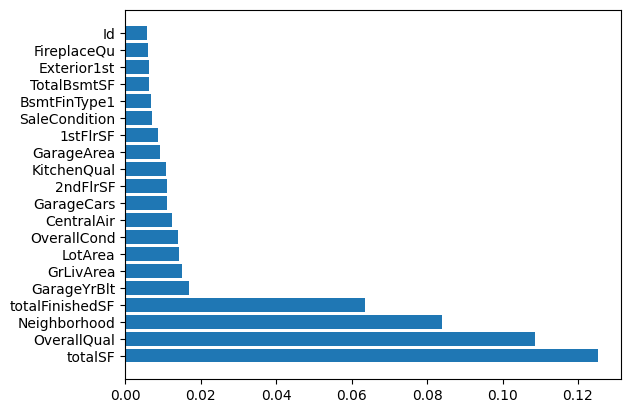

In [40]:
important = perm_result.importances_mean
important_indices = np.argsort(important)[::-1]
for f, i in zip(X_train.columns[important_indices] , important[important_indices]):
    print(f, ' : ', i)

feat_count = 20
plt.barh(range(feat_count), important[important_indices][:feat_count])
plt.yticks(range(feat_count),X_train.columns[important_indices][:feat_count])
plt.show()

# HistGBR Feature Engineering

We don't have many features with strong predicting power so going to see if we can engineer some better ones. Common real estate variables that aren't present are total square footage and total number of bathrooms

In [128]:
train['totalBath'] = train['FullBath'] + train['HalfBath'] + train['BsmtFullBath'] + train['BsmtHalfBath']
train['totalSF'] = train['1stFlrSF'] + train['2ndFlrSF'] + train['TotalBsmtSF']
train['totalFinishedSF'] = train['1stFlrSF'] + train['2ndFlrSF'] + train['TotalBsmtSF'] - train['BsmtUnfSF']
train['age'] = train['YrSold'] - train['YearRemodAdd']

In [129]:
X = train.loc[:,train.columns != 'SalePrice']
y = train.loc[:,'SalePrice']


X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y)

featEng = HistGradientBoostingRegressor(categorical_features="from_dtype")
featEng.fit(X_train,y_train.values.ravel())

perm_result = permutation_importance(featEng, X_train, y_train, n_repeats = 15,scoring = 'neg_root_mean_squared_log_error')
important = perm_result.importances_mean
important_indices = np.argsort(important)[::-1]
for f, i in zip(X_train.columns[important_indices] , important[important_indices]):
    print(f, ' : ', i)

OverallQual  :  0.13529729979811064
totalSF  :  0.12301268955785312
Neighborhood  :  0.08082864633051846
totalFinishedSF  :  0.06210341424700453
LotArea  :  0.016060799348443597
OverallCond  :  0.015867943856434245
CentralAir  :  0.012000919670246983
GarageArea  :  0.011188983409020598
totalBath  :  0.010935529048121898
SaleCondition  :  0.009514931064797508
GrLivArea  :  0.008997510201426666
FireplaceQu  :  0.008837500361776876
YearBuilt  :  0.00792998288641039
YearRemodAdd  :  0.007627190927275955
1stFlrSF  :  0.007367543709891688
2ndFlrSF  :  0.0073017050574629315
FullBath  :  0.007117211807835988
GarageFinish  :  0.007106793726308053
GarageCars  :  0.0069598976108839455
TotalBsmtSF  :  0.006396129360993296
age  :  0.005730547294794946
BsmtFinSF1  :  0.005718131472434069
LotFrontage  :  0.005637757315299119
KitchenQual  :  0.005585941680259752
Id  :  0.005584371178563972
GarageYrBlt  :  0.005231242034107072
MasVnrArea  :  0.004630317274110868
MoSold  :  0.0044917948829807175
MSSubCl

In [12]:
print(featEng.score(X_test,y_test))
root_mean_squared_error(y_test, featEng.predict(X_test))


0.8395086259298702


31148.755223928234

In [16]:
scores = []
for i in range(1,len(X_train.columns) + 1):
    #columns are sorted by importance, so selecting the top i columns every loop
    top_feat = X_train.columns[important_indices][:i]
    
    X_train_slim = X_train[top_feat]
    X_test_slim = X_test[top_feat]
    
    reg_slim = HistGradientBoostingRegressor(categorical_features="from_dtype").fit(X_train_slim,y_train)
    scores.append((i, reg_slim.score(X_test_slim,y_test)))

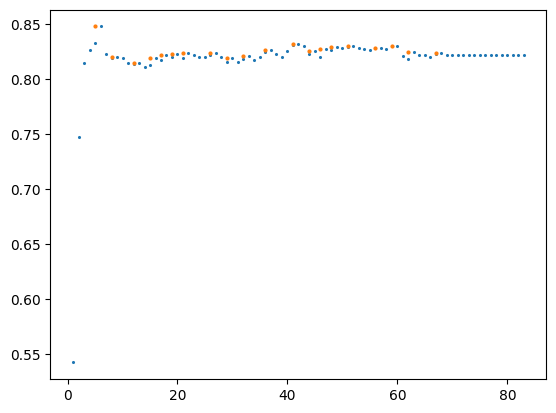

In [17]:
x,y = zip(*scores)

plt.scatter(x,y, s = 1.5)
plt.scatter(find_peaks(y)[0],np.array(y)[find_peaks(y)[0]], s = 4)

# Hyperparameter tuning
Limiting to just the top 10 features for hypertuning

In [152]:
top_feat = X_train.columns[important_indices][:10]
X = train.loc[:,top_feat]
y = train.loc[:,'SalePrice']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y)

In [54]:
tuningModel = HistGradientBoostingRegressor(categorical_features="from_dtype")
tuningModel.fit(X_train,y_train.values.ravel())

#parameters to tune
parameters = {
 'max_iter': [50,100,150,200],
 'learning_rate': [0.01,0.1,0.2,0.3],
 'max_depth' : [25, 50,55,60,75],
 'l2_regularization': [0.5,1,1.5],
 'scoring': ['root_mean_squared_log_error'],
 }

#this search takes rather long, don't run unless you have time
grid = GridSearchCV(tuningModel, parameters, n_jobs=5, cv=5, scoring ='neg_root_mean_squared_log_error')
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=HistGradientBoostingRegressor(categorical_features='from_dtype'),
             n_jobs=5,
             param_grid={'l2_regularization': [0.5, 1, 1.5],
                         'learning_rate': [0.01, 0.1, 0.2, 0.3],
                         'max_depth': [25, 50, 55, 60, 75],
                         'max_iter': [50, 100, 150, 200],
                         'scoring': ['root_mean_squared_log_error']},
             scoring='neg_root_mean_squared_log_error')

In [55]:
# Print the best parameters and scorefound
print(grid.best_params_,'\n\n',grid.best_score_)


{'l2_regularization': 0.5, 'learning_rate': 0.1, 'max_depth': 25, 'max_iter': 50, 'scoring': 'root_mean_squared_log_error'} 

 -0.142687266334874


In [159]:
params = {'l2_regularization': 0.25, 'learning_rate': 0.03, 'max_depth': 3, 'max_iter': 1000}
finalModel = HistGradientBoostingRegressor(**params,categorical_features="from_dtype")
finalModel.fit(X_train,y_train.values.ravel())

HistGradientBoostingRegressor(categorical_features='from_dtype')

In [160]:
print(root_mean_squared_error(y_train, finalModel.predict(X_train)))
root_mean_squared_error(y_test, finalModel.predict(X_test))

13251.208555554325


30690.54030396169

# Normal Gradient Boosting Regression

In [6]:
train = pd.read_csv('train.csv')
train['totalBath'] = train['FullBath'] + train['HalfBath'] + train['BsmtFullBath'] + train['BsmtHalfBath']
train['totalSF'] = train['1stFlrSF'] + train['2ndFlrSF'] + train['TotalBsmtSF']
train['totalFinishedSF'] = train['1stFlrSF'] + train['2ndFlrSF'] + train['TotalBsmtSF'] - train['BsmtUnfSF']
train['ageRemod'] = train['YrSold'] - train['YearRemodAdd']
train['ageOrig'] = train['YrSold'] - train['YearBuilt']

#Setting up Ordinal Encoder
conditionRanking = ['Ex', 'Gd','TA','Fa','Po','NA']
exposRank = ['Gd','Av','Mn','No','NA']
finRank = ['GLQ','ALQ','BLQ','Rec','LwQ','Unf','NA']
Orders = [conditionRanking, conditionRanking,conditionRanking, conditionRanking, exposRank, finRank,finRank,conditionRanking]
Ordinal_features = ['ExterQual', 'ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','KitchenQual']

Non_ordinal_features = cat_features.copy()
Non_ordinal_features[Ordinal_features] = False
Non_ordinal_features_list = Non_ordinal_features[Non_ordinal_features == True].keys()

numeric_features = pd.Series(~cat_features)
numeric_features.drop('SalePrice',inplace = True)
numeric_features_list = numeric_features[numeric_features == True].keys()

X = train.loc[:,train.columns != 'SalePrice']
y = train.loc[:,'SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X,y)

In [35]:
cat_pipeline = Pipeline(
    steps = [("fillNA",SimpleImputer(strategy = "constant",fill_value = "NA") )
            #,("oneHot",OneHotEncoder(handle_unknown = "infrequent_if_exist"))
            ,('TargetEncoder',TargetEncoder(target_type = 'continuous'))]
)
ordinal_pipeline = Pipeline(
    steps = [("fillNA",SimpleImputer(strategy = "constant",fill_value = "NA")),
              ('ordinalEncoder',OrdinalEncoder(categories = Orders))]
)
numeric_pipeline = Pipeline(
    steps = [("fillNA", SimpleImputer(strategy = "constant",fill_value = 0))]
)

preprocessor = ColumnTransformer(
    transformers = [("cat_steps", cat_pipeline, Non_ordinal_features_list),
                   ("ordinal_steps",ordinal_pipeline,Ordinal_features),
                   ("numeric_steps",numeric_pipeline,numeric_features_list)]
   # ,remainder = 'passthrough'
)
sfm = SelectFromModel(GradientBoostingRegressor(), threshold = "1.5*median")
rfecv = RFECV(GradientBoostingRegressor(),cv = 3, step = 2, 
              scoring ='neg_root_mean_squared_log_error', n_jobs = 4)

#search = GridSearchCV(GradientBoostingRegressor(), parameters, cv=5, n_jobs = -1, scoring ='neg_root_mean_squared_log_error')

gbr_pipe = Pipeline(
    steps = [("preprocessor",preprocessor),("sfm",sfm), ("regressor",GradientBoostingRegressor(learning_rate = 0.005, max_depth= 5, n_estimators = 2500))]
)
#learning_rate = 0.01, max_depth = 5, n_estimators = 2500

In [9]:
parameters = {
 'regressor__n_estimators': [1500,2000,2500,3000,3500],
 'regressor__learning_rate': [0.1, 0.01, 0.005, 0.001],
 'regressor__max_depth' : [5,10,20,30]
    
 }

search = GridSearchCV(gbr_pipe, parameters, cv=5, n_jobs = -1, scoring ='neg_root_mean_squared_log_error')


In [10]:
search.fit(X_train,y_train)
print(search.best_params_,'\n\n',search.best_score_)


C:\Users\evanh\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'regressor__learning_rate': 0.005, 'regressor__max_depth': 5, 'regressor__n_estimators': 2500} 

 -0.1419568918636692


In [36]:
gbr_pipe.fit(X,y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat_steps',
                                                  Pipeline(steps=[('fillNA',
                                                                   SimpleImputer(fill_value='NA',
                                                                                 strategy='constant')),
                                                                  ('TargetEncoder',
                                                                   TargetEncoder(target_type='continuous'))]),
                                                  Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1...
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'],
      dtype='object'))])),
                ('sfm',
                 SelectFromModel(estimator=GradientBoostingRegressor(),
                                 threshold='1.5*median')),
                ('regressor',
                 GradientBoostingRegressor(learning_rate=0.005, max_depth=5,
                                           n_estimators=2500))])

# Submission

In [307]:
submission = gbr_pipe.fit(X,y)

In [310]:
test = pd.read_csv('test.csv')
test['totalBath'] = test['FullBath'] + test['HalfBath'] + test['BsmtFullBath'] + test['BsmtHalfBath']
test['totalSF'] = test['1stFlrSF'] + test['2ndFlrSF'] + test['TotalBsmtSF']
test['totalFinishedSF'] = test['1stFlrSF'] + test['2ndFlrSF'] + test['TotalBsmtSF'] - test['BsmtUnfSF']
test['ageRemod'] = test['YrSold'] - test['YearRemodAdd']
test['ageOrig'] = test['YrSold'] - test['YearBuilt']




In [312]:
test['SalePrice']= gbr_pipe.predict(test)


In [313]:
test

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,MoSold,YrSold,SaleType,SaleCondition,totalBath,totalSF,totalFinishedSF,ageRemod,ageOrig,SalePrice
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,6,2010,WD,Normal,1.0,1778.0,1508.0,49,49,132233.390535
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,6,2010,WD,Normal,2.0,2658.0,2252.0,52,52,173419.486245
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,3,2010,WD,Normal,3.0,2557.0,2420.0,12,13,187816.624651
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,6,2010,WD,Normal,3.0,2530.0,2206.0,12,12,196449.046272
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,1,2010,WD,Normal,2.0,2560.0,1543.0,18,18,190637.199581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,6,2006,WD,Normal,2.0,1638.0,1092.0,36,36,80264.750907
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,4,2006,WD,Abnorml,2.0,1638.0,1344.0,36,36,83420.387063
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,9,2006,WD,Abnorml,2.0,2448.0,2448.0,10,46,144404.545133
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,7,2006,WD,Normal,2.0,1882.0,1307.0,14,14,113949.274004


In [314]:
test[['Id','SalePrice']].to_csv('sub4.csv', index = False)

In [104]:
str(datetime.datetime.now())

'2024-04-15 13:47:19.979201'